In [1]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-08 17:55:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-08 17:55:15 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-07-08 17:55:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  41.7MB/s    in 38s     

2023-07-08 17:55:57 (40.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [6]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


In [7]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = IMG_SIZE+(3,), name = 'Input-Layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global-average-pooling-layer')(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name= 'output-layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [8]:
# Compile
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model_1.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 75s 247ms/step - loss: 3.3797 - accuracy: 0.2756 - val_loss: 2.2880 - val_accuracy: 0.4939
Epoch 2/5
237/237 [==============================] - 46s 190ms/step - loss: 2.1973 - accuracy: 0.5032 - val_loss: 1.8539 - val_accuracy: 0.5445
Epoch 3/5
237/237 [==============================] - 69s 289ms/step - loss: 1.8202 - accuracy: 0.5657 - val_loss: 1.6960 - val_accuracy: 0.5704
Epoch 4/5
237/237 [==============================] - 40s 167ms/step - loss: 1.6052 - accuracy: 0.6131 - val_loss: 1.6264 - val_accuracy: 0.5765
Epoch 5/5
237/237 [==============================] - 38s 160ms/step - loss: 1.4447 - accuracy: 0.6462 - val_loss: 1.5814 - val_accuracy: 0.5853


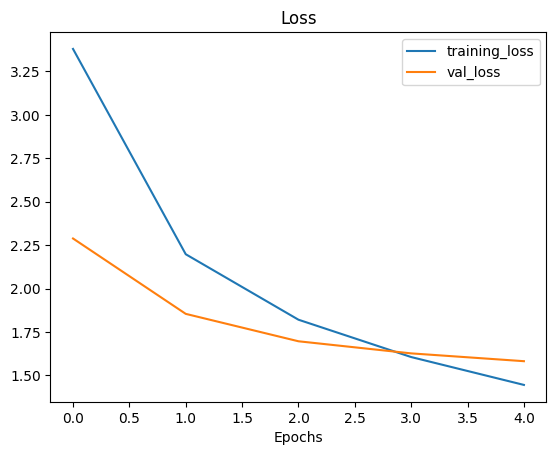

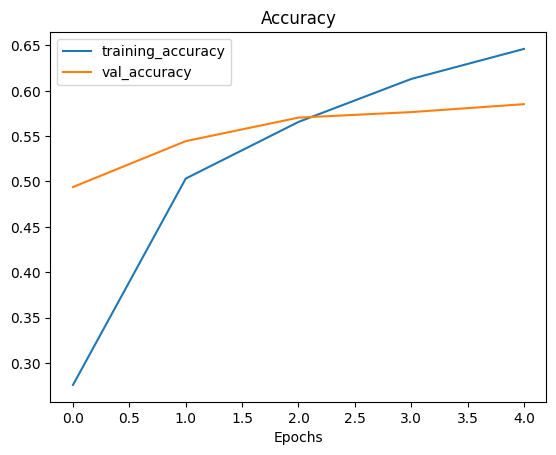

In [9]:
plot_loss_curves(history_all_classes_10_percent)

In [10]:
model_1.evaluate(test_data)

790/790 [==============================] - 65s 81ms/step - loss: 1.5879 - accuracy: 0.5827


[1.5879031419754028, 0.5826534628868103]

In [11]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [12]:
model_1.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model_1.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 50s 165ms/step - loss: 1.2204 - accuracy: 0.6813 - val_loss: 1.5285 - val_accuracy: 0.5951
Epoch 6/10
237/237 [==============================] - 33s 137ms/step - loss: 1.0959 - accuracy: 0.7072 - val_loss: 1.5068 - val_accuracy: 0.5998
Epoch 7/10
237/237 [==============================] - 33s 136ms/step - loss: 1.0107 - accuracy: 0.7329 - val_loss: 1.4795 - val_accuracy: 0.6062
Epoch 8/10
237/237 [==============================] - 32s 135ms/step - loss: 0.9596 - accuracy: 0.7471 - val_loss: 1.4869 - val_accuracy: 0.6070
Epoch 9/10
237/237 [==============================] - 34s 141ms/step - loss: 0.9036 - accuracy: 0.7591 - val_loss: 1.4975 - val_accuracy: 0.6028
Epoch 10/10
237/237 [==============================] - 34s 143ms/step - loss: 0.8382 - accuracy: 0.7765 - val_loss: 1.4888 - val_accuracy: 0.6014


In [13]:
model_1.evaluate(test_data)

790/790 [==============================] - 71s 89ms/step - loss: 1.5019 - accuracy: 0.6029


[1.501851201057434, 0.6029306650161743]

In [14]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [15]:
 # Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [16]:
model_1.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-4/4),
              metrics = ['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 15 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model_1.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent_fine_tune.epoch[-1]) # start from previous last epoch

Epoch 10/15
237/237 [==============================] - 47s 157ms/step - loss: 0.7433 - accuracy: 0.8048 - val_loss: 1.4962 - val_accuracy: 0.6070
Epoch 11/15
237/237 [==============================] - 32s 130ms/step - loss: 0.7175 - accuracy: 0.8025 - val_loss: 1.5091 - val_accuracy: 0.6057
Epoch 12/15
237/237 [==============================] - 33s 136ms/step - loss: 0.7108 - accuracy: 0.8070 - val_loss: 1.5236 - val_accuracy: 0.6046
Epoch 13/15
237/237 [==============================] - 34s 141ms/step - loss: 0.6762 - accuracy: 0.8174 - val_loss: 1.5173 - val_accuracy: 0.6030
Epoch 14/15
237/237 [==============================] - 32s 134ms/step - loss: 0.6717 - accuracy: 0.8173 - val_loss: 1.5337 - val_accuracy: 0.6028
Epoch 15/15
237/237 [==============================] - 33s 136ms/step - loss: 0.6505 - accuracy: 0.8220 - val_loss: 1.5394 - val_accuracy: 0.6049


In [17]:
results_all_classes_10_percent_fine_tune = model_1.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 62s 78ms/step - loss: 1.5425 - accuracy: 0.6052


[1.5425043106079102, 0.6052277088165283]

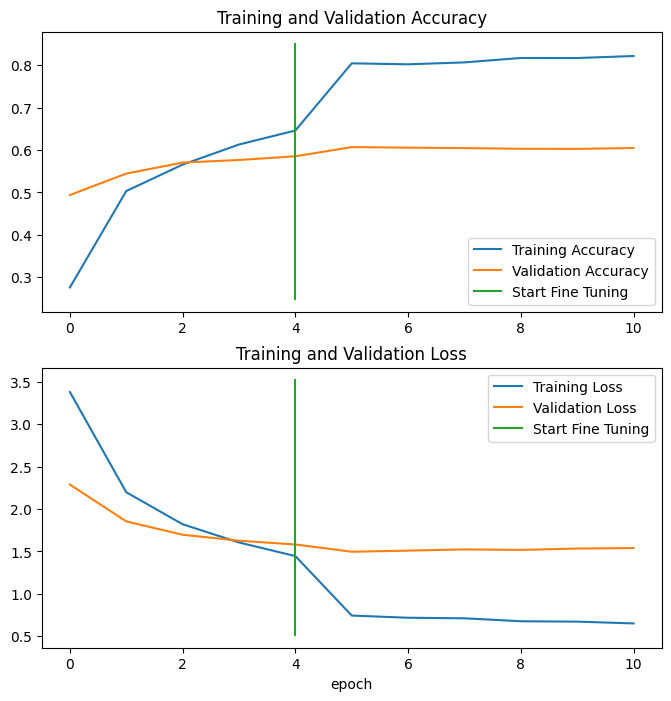

In [18]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [19]:
inputs = tf.keras.layers.Input(shape = IMG_SIZE+(3,), name = 'Input-Layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global-average-pooling-layer')(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name= 'output-layer')(x)

model_2 = tf.keras.Model(inputs, outputs)



base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False



In [20]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [21]:
model_2.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 5 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model_2.fit(test_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=train_data_all_10_percent,
                                                     validation_steps=int(0.75 * len(train_data_all_10_percent)), # validate on 75% of the test data
                                                    #  initial_epoch=history_all_classes_10_percent.epoch[-1]
                                                       batch_size = 32) # start from previous last epoch

Epoch 1/5
790/790 [==============================] - 107s 122ms/step - loss: 2.5988 - accuracy: 0.3781 - val_loss: 1.9358 - val_accuracy: 0.5044
Epoch 2/5
790/790 [==============================] - 93s 117ms/step - loss: 1.6387 - accuracy: 0.5692 - val_loss: 1.7235 - val_accuracy: 0.5553
Epoch 3/5
790/790 [==============================] - 88s 110ms/step - loss: 1.4225 - accuracy: 0.6220 - val_loss: 1.6076 - val_accuracy: 0.5814
Epoch 4/5
790/790 [==============================] - 86s 108ms/step - loss: 1.2982 - accuracy: 0.6518 - val_loss: 1.5502 - val_accuracy: 0.5909
Epoch 5/5
790/790 [==============================] - 91s 115ms/step - loss: 1.2029 - accuracy: 0.6755 - val_loss: 1.5123 - val_accuracy: 0.6022


<Axes: >

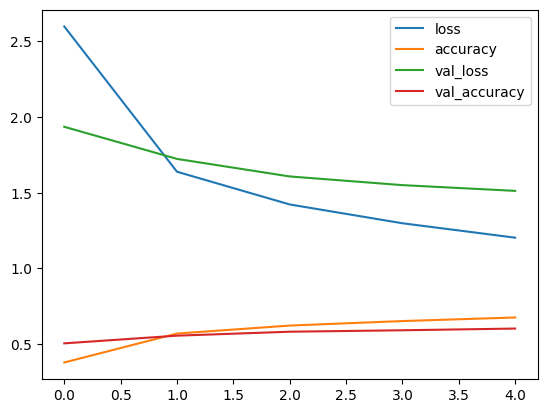

In [22]:
import pandas as pd
pd.DataFrame(history_all_classes_10_percent_fine_tune.history).plot()

In [42]:
# Make predictions with model
pred_probs = model_2.predict(test_data, verbose=1) # set verbosity to see how long it will take

790/790 [==============================] - 73s 87ms/step


In [43]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([63, 98, 10, 91, 87,  1, 19, 83, 86, 71])

In [47]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

1/1 [==============================] - 0s 29ms/step


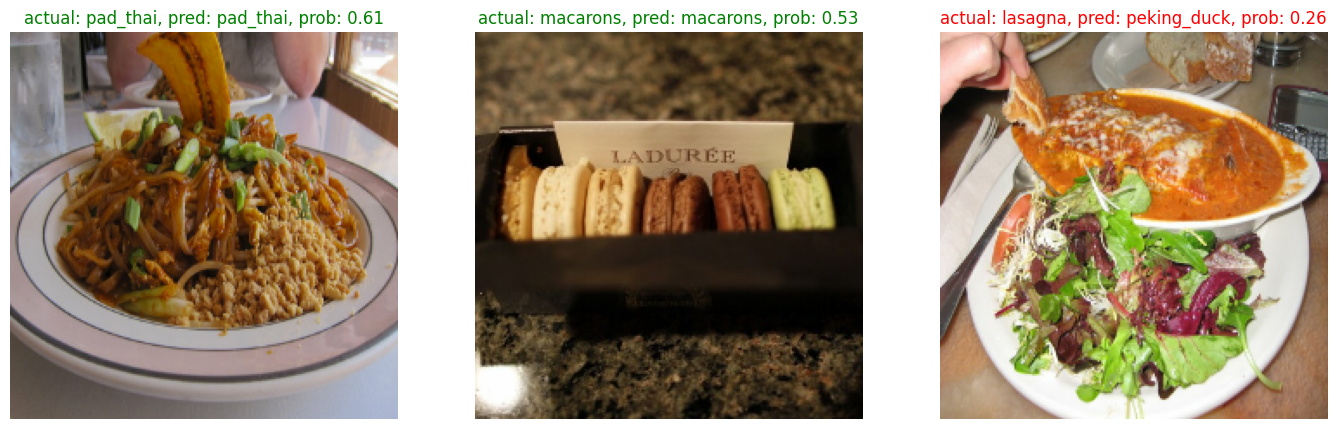

In [49]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model_2.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);